In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sign-language-digits-dataset/Y.npy
/kaggle/input/sign-language-digits-dataset/X.npy
/kaggle/input/sign-language-digits-dataset/Sign-language-digits-dataset/Y.npy
/kaggle/input/sign-language-digits-dataset/Sign-language-digits-dataset/X.npy


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

sign-language-digits-dataset



In [3]:
x = np.load('../input/sign-language-digits-dataset/X.npy')
y = np.load('../input/sign-language-digits-dataset/Y.npy')

In [4]:
x = np.concatenate((x[204:409], x[822:1027]), axis = 0)
y = np.concatenate((np.zeros(205), np.ones(205))).reshape(410,1)
print("x shape: ", x.shape)
print("y shape: ", y.shape)

x shape:  (410, 64, 64)
y shape:  (410, 1)


afterwards, i shall flatten x from a 3d array into a 2d array because the input layer of the model is 1d

In [5]:
x_flatten = x.reshape(410, 64 * 64)

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_flatten, y, test_size=0.15, random_state=42)
print("x train shape : ", x_train.shape)
print("x test shape : ", x_test.shape)
print("y train shape : ", y_train.shape)
print("y test shape : ", y_test.shape)

x train shape :  (348, 4096)
x test shape :  (62, 4096)
y train shape :  (348, 1)
y test shape :  (62, 1)


In [7]:
x_train = x_train.T
x_test = x_test.T
y_train = y_train.T
y_test = y_test.T
print("x train shape : ", x_train.shape)
print("x test shape : ", x_test.shape)
print("y train shape : ", y_train.shape)
print("y test shape : ", y_test.shape)

x train shape :  (4096, 348)
x test shape :  (4096, 62)
y train shape :  (1, 348)
y test shape :  (1, 62)


In [8]:
def initialise(dimension):
    w = np.full((dimension, 1), 0.01) #w is a column vector
    b = 0.0
    return w, b

Since I am doing a classification tasks, the loss function shall be the cross-entropy loss which has the following formula:
$ loss = -y_ilog(\hat{y}_i) -(1-y_i)log(1-\hat{y}_i) $


I shall let $J(w) = \frac{1}{m} \sum_{i=1}^{m} [-y_ilog(\hat{y_i})-(1-y_i)log(1-\hat{y_i})]$ where m is the number of training examples (images/data) because we want to find the average cost/loss of all images being used. Averaging helps to normalise the loss and gradients, making them independent of the number of training examples and ensuring that the weights are not disproprtionately small or large.


You can also calculate the partial derivative of the loss function with respect to the $j^{th}$ weight which would be $\frac{\partial{loss}}{\partial{w_j}} = \frac{1}{m} \sum_{i=1}^{m} \left(\hat{y}_i  - y_i \right) x_i^{(j)}$ where j is the weight $\in \mathbb{Z}$ and $ 1\le j \le 4096$ 


The equation for gradient descent is: $ w := w - \alpha \frac{\partial{loss}}{\partial{w}} $ where w is the weight


The vectorised gradient is then $\nabla_{w} J(w) = \frac{1}{m} X^T \left( h_w(X) - y \right)$ where the first layer of the resulting matrix is going to be $\frac{\partial{loss}}{\partial{w_i}}$, the second layer is $\frac{\partial{loss}}{\partial{w_2}}$, and so on...


In [9]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

def ce_loss(y_train, y_hat):
    #each row of the resulting vector is the loss/cost for each images
    #need to find and return the average of the cost
    return np.mean(-y_train * np.log(y_hat) - (1 - y_train) * np.log(1 - y_hat))

def forward_backward(w, b, x_train, y_train):
    #forward propagation
    z = np.dot(w.T, x_train) + b
    y_hat = sigmoid(z) #y_hat and y_train are also a row vector with 348 columns (1, 348)
    loss = ce_loss(y_train, y_hat)
    
    #backward propagation
    #return the partial derivative of loss function with respect to each parameters
    #x_train has a shape of (4096, 348)
    #therefore, I am performing transposition of y_train - y_hat so that is has a shape of (348, 1)
    d_weights = np.dot(x_train, (y_hat - y_train).T)/x_train.shape[1] #shape is (4096, 1) -> column vector
    d_bias = np.sum(y_hat - y_train)/x_train.shape[1]    
    gradients = {"weights": d_weights, "bias": d_bias}
    return gradients, loss

In [10]:
def fit(epoch, alpha, x_train, y_train):
    #return parameters, gradients, cost_list
    #plotting graph of cost against iteration rounds
    w, b = initialise(x_train.shape[0])
    cost_list = list()
    cost2_list = list()
    
    for i in range(epoch):
        gradients, loss = forward_backward(w, b, x_train, y_train)
        w -= (alpha * gradients["weights"])
        b -= (alpha * gradients["bias"])
        cost_list.append(loss)
        if i % 10 == 0:
            cost2_list.append(loss)
            print(f"Cost after iteration {i}: {loss}")
    plt.plot([i * 10 for i in range(len(cost2_list))], cost2_list)
    plt.xlabel("Number of epochs")
    plt.ylabel("Cost")
    plt.show()
    return {"weights":w, "bias":b}, gradients, cost_list

In [11]:
def predict(epoch, alpha, x_train, y_train, x_test):
    weights_and_bias, gradients, cost_list = fit(epoch, alpha, x_train,y_train)
    w = weights_and_bias["weights"]
    b = weights_and_bias["bias"]
    z = np.dot(w.T, x_test) + b
    y_hat = sigmoid(z)
    return np.where(y_hat >= 0.5, 1, 0)

Cost after iteration 0: 14.014222401929988
Cost after iteration 10: 1.9185348888991882
Cost after iteration 20: 1.7503649743452963
Cost after iteration 30: 1.6535238227860232
Cost after iteration 40: 1.5609559755938174
Cost after iteration 50: 1.4577445315300086
Cost after iteration 60: 1.3354950822952356
Cost after iteration 70: 1.191800023944936
Cost after iteration 80: 1.0275108866404417
Cost after iteration 90: 0.8430995927556606
Cost after iteration 100: 0.6398899598449164
Cost after iteration 110: 0.4325953153240531
Cost after iteration 120: 0.27819155102645077
Cost after iteration 130: 0.22160871009229455
Cost after iteration 140: 0.20897225691268714
Cost after iteration 150: 0.2034150756197586
Cost after iteration 160: 0.19875375473314347
Cost after iteration 170: 0.19444591698389074
Cost after iteration 180: 0.19043273744029712
Cost after iteration 190: 0.18668325341088549


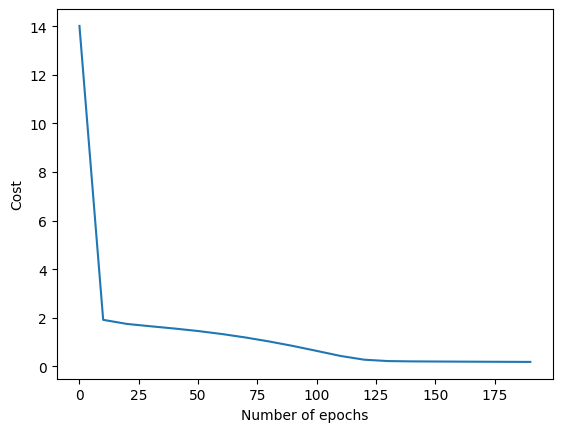

Cost after iteration 0: 14.014222401929988
Cost after iteration 10: 1.9185348888991882
Cost after iteration 20: 1.7503649743452963
Cost after iteration 30: 1.6535238227860232
Cost after iteration 40: 1.5609559755938174
Cost after iteration 50: 1.4577445315300086
Cost after iteration 60: 1.3354950822952356
Cost after iteration 70: 1.191800023944936
Cost after iteration 80: 1.0275108866404417
Cost after iteration 90: 0.8430995927556606
Cost after iteration 100: 0.6398899598449164
Cost after iteration 110: 0.4325953153240531
Cost after iteration 120: 0.27819155102645077
Cost after iteration 130: 0.22160871009229455
Cost after iteration 140: 0.20897225691268714
Cost after iteration 150: 0.2034150756197586
Cost after iteration 160: 0.19875375473314347
Cost after iteration 170: 0.19444591698389074
Cost after iteration 180: 0.19043273744029712
Cost after iteration 190: 0.18668325341088549


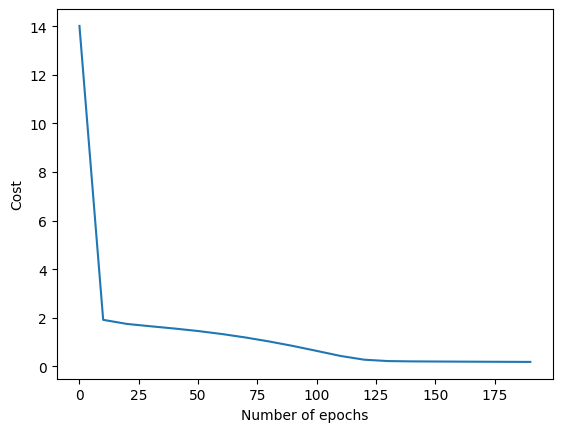

here is the prediction for the testing dataset: 
[[0 0 0 0 0 0 1 1 1 1 0 1 1 1 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 1 0 1 0
  1 1 0 1 1 1 1 1 0 1 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1]]

summary of results:
training accuracy:  93.67816091954023
testing accuracy:  95.16129032258065


In [12]:
def log_regression(epoch, alpha, x_train, y_train, x_test, y_test):
    #training accuracy
    y_train_prediction = predict(epoch, alpha, x_train, y_train, x_train)
    y_test_prediction = predict(epoch, alpha, x_train, y_train, x_test)
    
    print("here is the prediction for the testing dataset: ")
    print(y_test_prediction)
    
    print("\nsummary of results:")
    training_accuracy = (np.sum(y_train_prediction == y_train)/y_train.shape[1]) * 100
    print("training accuracy: ", training_accuracy)
    
    test_accuracy = (np.sum(y_test_prediction == y_test)/y_test.shape[1]) * 100
    print("testing accuracy: ", test_accuracy)

log_regression(200, 0.009, x_train, y_train, x_test, y_test)